In [1]:
import os
import sys
import pandas as pd

TOP_DIR = os.path.realpath('../../../..')

if TOP_DIR not in sys.path: sys.path.append(TOP_DIR)
print( TOP_DIR)

/home/runner/work/leeds-2023/leeds-2023


In [2]:
from lib.util.geo import postcode_formatter, postcode_to_ward_code

In [3]:
ticket_data = pd.read_csv('../../../../working/metrics/ticketing/orders.csv', parse_dates=['created_at', 'event_date'])

In [4]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   object                  3457 non-null   object        
 1   id                      3457 non-null   object        
 2   postcode_from_question  3286 non-null   object        
 3   postcode_from_address   38 non-null     object        
 4   created_at              3457 non-null   datetime64[ns]
 5   event_id                3457 non-null   object        
 6   event_name              3457 non-null   object        
 7   event_date              3457 non-null   datetime64[ns]
 8   number_of_tickets       3457 non-null   int64         
 9   referral_tag            0 non-null      float64       
 10  status                  3457 non-null   object        
 11  status_message          57 non-null     object        
dtypes: datetime64[ns](2), float64(1), int64(1), obje

In [5]:
completed_orders = ticket_data.loc[~ticket_data.status.isin(['cancelled']), ticket_data.columns]

In [6]:
completed_orders['ward_code'] = completed_orders.loc[:, ['postcode_from_question', 'postcode_from_address']].bfill().iloc[:, 0].pipe(postcode_formatter).map(postcode_to_ward_code)

In [7]:
OUTPUT_DIR = '../../../../data/metrics/events/tickets/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [8]:
completed_orders.loc[:, [
    'created_at',
    'event_id',
    'event_date',
    'number_of_tickets',
    'ward_code',
]].sort_values(['created_at', 'event_id']).to_csv(os.path.join(OUTPUT_DIR, 'orders.csv'), index=False)

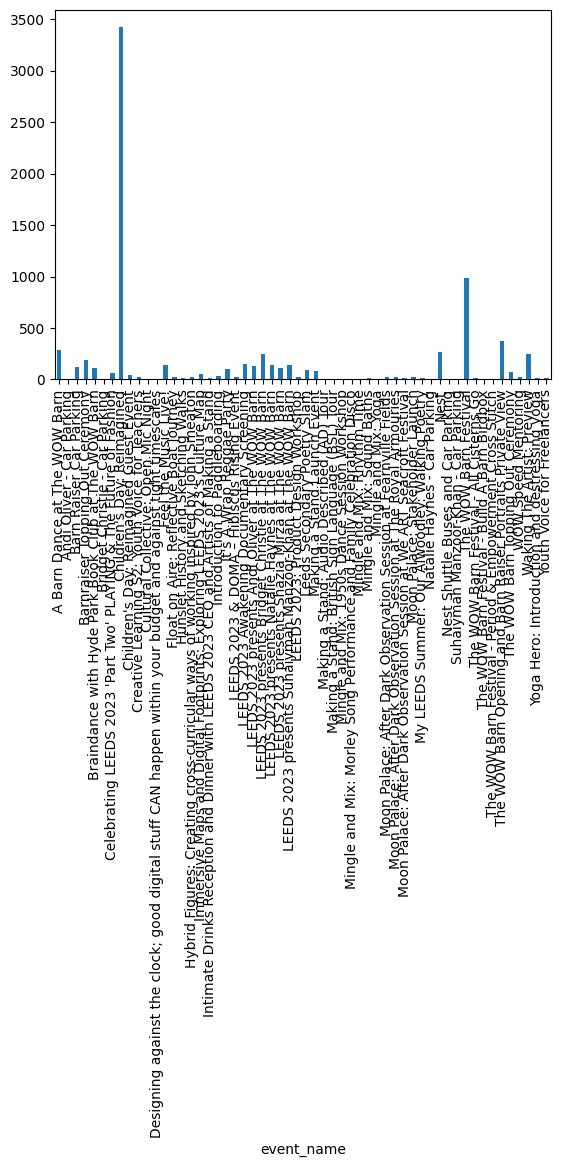

In [9]:
chart = completed_orders.groupby(['event_name']).number_of_tickets.sum().plot.bar()

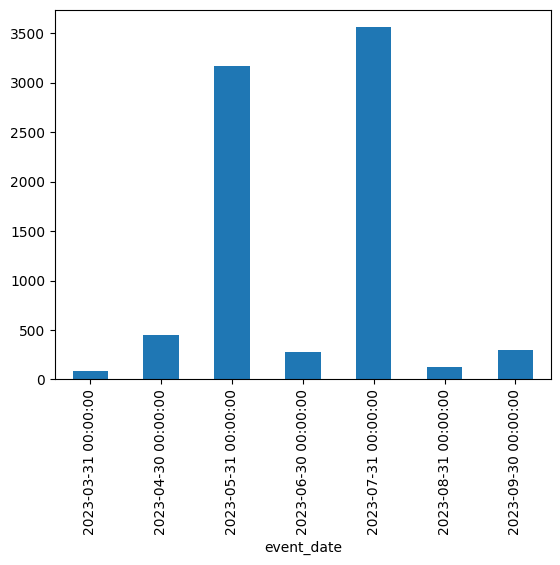

In [10]:
chart = completed_orders.groupby(['event_date']).number_of_tickets.sum().resample('M').sum().plot.bar()
